In [1]:
import tensorflow as tf
import os
import numpy as np
from matplotlib import pyplot as plt
import IPython

import utils
from dataset_generator import DatasetGenerator

os.chdir('../..') 

2023-04-27 09:34:38.921416: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-27 09:34:40.151007: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
price_dfs = utils.load_data('prices')
quarterly_financials_dfs = utils.load_data('quarterly_financials')

dfs = []
for (price_df, quarterly_financials_df) in zip(price_dfs, quarterly_financials_dfs):
    price_df = utils.clean_price_df(price_df)
    quarterly_financials_df = utils.clean_quarterly_financials_df(quarterly_financials_df)

    df = utils.join_quarterly_financials_df(price_df, quarterly_financials_df)

    df = df.drop(["Date", "end_date"])

    dfs.append(df)

train_dfs, val_dfs, test_dfs = utils.setup_data(dfs, .7, .2)

column_indices = {name: i for i, name in enumerate(train_dfs[0].columns)}


argument in operation 'asof_join' is not explicitly sorted

- If your data is ALREADY sorted, set the sorted flag with: '.set_sorted()'.
- If your data is NOT sorted, sort the 'expr/series/column' first.

This might become an error in a future version.
    
argument in operation 'asof_join' is not explicitly sorted

- If your data is ALREADY sorted, set the sorted flag with: '.set_sorted()'.
- If your data is NOT sorted, sort the 'expr/series/column' first.

This might become an error in a future version.
    
argument in operation 'asof_join' is not explicitly sorted

- If your data is ALREADY sorted, set the sorted flag with: '.set_sorted()'.
- If your data is NOT sorted, sort the 'expr/series/column' first.

This might become an error in a future version.
    
argument in operation 'asof_join' is not explicitly sorted

- If your data is ALREADY sorted, set the sorted flag with: '.set_sorted()'.
- If your data is NOT sorted, sort the 'expr/series/column' first.

This might become an 

In [3]:
label_columns = ['Adj Close']

single_step_window = DatasetGenerator(train_dfs, val_dfs, test_dfs, 1, 1, 1, label_columns)

wide_window = DatasetGenerator(train_dfs, val_dfs, test_dfs,  20, 20, 1, label_columns)

CONV_WIDTH = 3
conv_window = DatasetGenerator(train_dfs, val_dfs, test_dfs, CONV_WIDTH, 1, 1, label_columns)

LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = DatasetGenerator(train_dfs, val_dfs, test_dfs, INPUT_WIDTH, LABEL_WIDTH, 1, label_columns)

2023-04-27 09:34:42.101820: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-27 09:34:42.231852: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-27 09:34:42.232142: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

### Baseline

In [4]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]


In [5]:
baseline = Baseline(label_index=column_indices['Adj Close'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)


2023-04-27 09:34:46.368587: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_141' with dtype int32
	 [[{{node Placeholder/_141}}]]
2023-04-27 09:34:46.369826: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_140' with dtype int32
	 [[{{node Placeholder/_140}}]]


115/115 [==============================] - 1s 3ms/step - loss: 0.0198 - mean_absolute_error: 0.0928


2023-04-27 09:34:46.981015: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_127' with dtype double and shape [354,13]
	 [[{{node Placeholder/_127}}]]
2023-04-27 09:34:46.982977: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]


In [6]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

2023-04-27 09:34:47.843686: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-04-27 09:34:47.844291: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [2480]
	 [[{{node Placeholder/_8}}]]


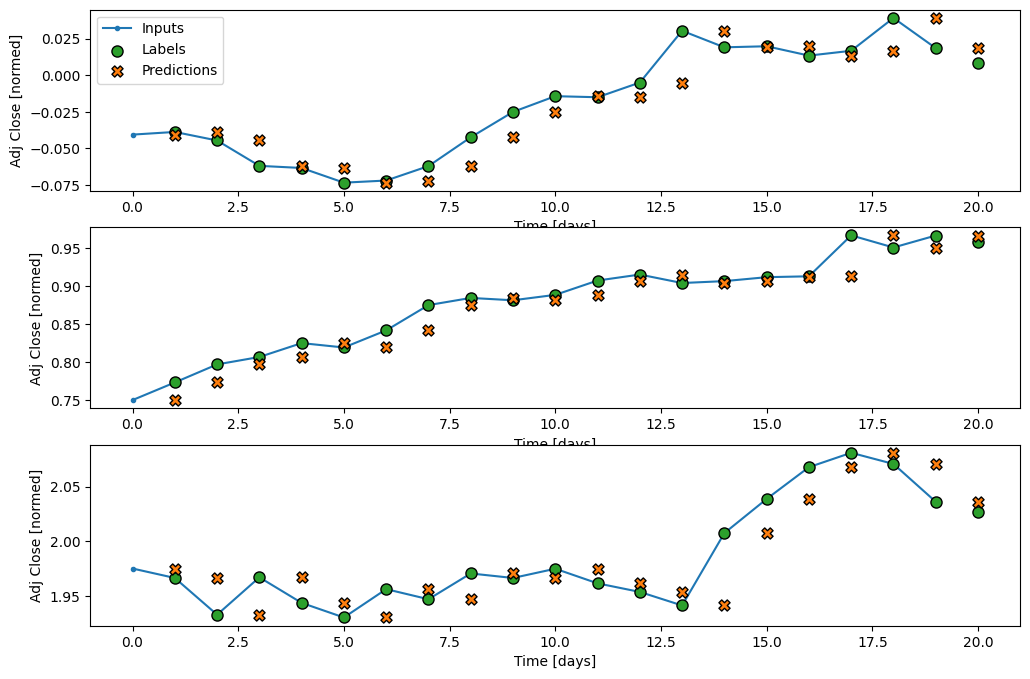

In [7]:
wide_window.windows[0].plot(baseline)

### Linear

In [8]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [9]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20


2023-04-27 09:34:49.279134: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_63' with dtype double and shape [2472,13]
	 [[{{node Placeholder/_63}}]]
2023-04-27 09:34:49.280110: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_63' with dtype double and shape [2472,13]
	 [[{{node Placeholder/_63}}]]
2023-04-27 09:34:50.964575: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x21ea5d40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-27 09:34:50.964625: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA

  1/391 [..............................] - ETA: 15:12 - loss: 11.7709 - mean_absolute_error: 2.6522

2023-04-27 09:34:51.503019: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


391/391 [==============================] - 4s 5ms/step - loss: 3.5082 - mean_absolute_error: 1.3443 - val_loss: 16.7942 - val_mean_absolute_error: 3.6332
Epoch 2/20
391/391 [==============================] - 2s 4ms/step - loss: 0.3193 - mean_absolute_error: 0.4198 - val_loss: 1.4493 - val_mean_absolute_error: 0.9900
Epoch 3/20
391/391 [==============================] - 2s 4ms/step - loss: 0.1476 - mean_absolute_error: 0.2589 - val_loss: 0.4865 - val_mean_absolute_error: 0.5796
Epoch 4/20
391/391 [==============================] - 2s 4ms/step - loss: 0.0869 - mean_absolute_error: 0.1743 - val_loss: 0.2105 - val_mean_absolute_error: 0.3721
Epoch 5/20
391/391 [==============================] - 2s 4ms/step - loss: 0.0593 - mean_absolute_error: 0.1258 - val_loss: 0.1282 - val_mean_absolute_error: 0.2801
Epoch 6/20
391/391 [==============================] - 2s 4ms/step - loss: 0.0442 - mean_absolute_error: 0.1025 - val_loss: 0.1006 - val_mean_absolute_error: 0.2426
Epoch 7/20
391/391 [======

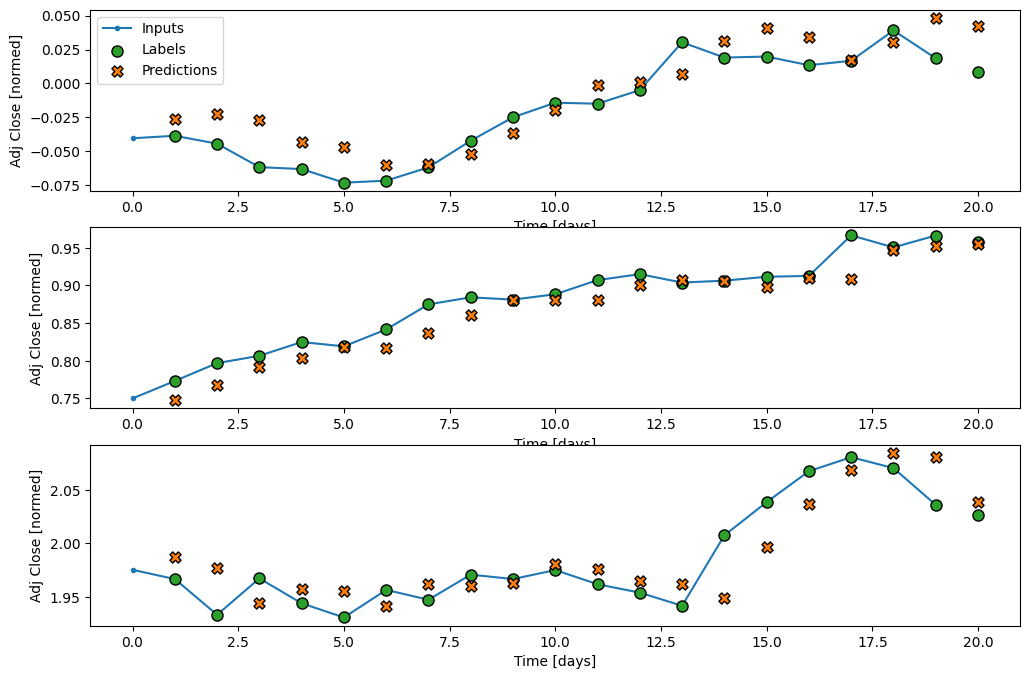

In [10]:
wide_window.windows[0].plot(linear)

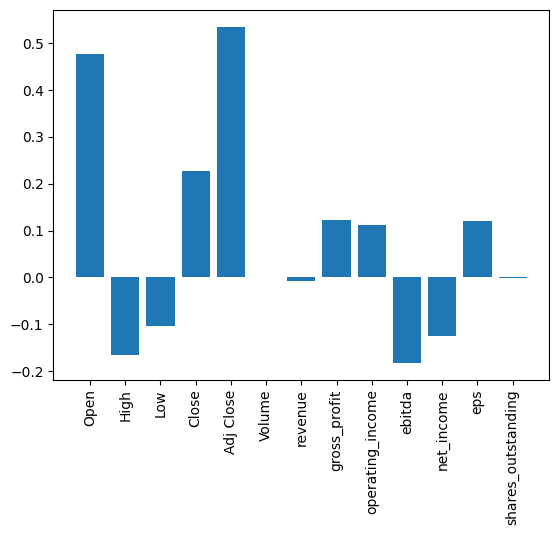

In [11]:
plt.bar(x = range(len(train_dfs[0].columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_dfs[0].columns)))
_ = axis.set_xticklabels(train_dfs[0].columns, rotation=90)

### Dense

In [12]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
391/391 [==============================] - 3s 5ms/step - loss: 0.0118 - mean_absolute_error: 0.0527 - val_loss: 0.0564 - val_mean_absolute_error: 0.1634
Epoch 2/20
391/391 [==============================] - 2s 5ms/step - loss: 0.0019 - mean_absolute_error: 0.0285 - val_loss: 0.0940 - val_mean_absolute_error: 0.2236
Epoch 3/20
115/115 [==============================] - 0s 3ms/step - loss: 0.0991 - mean_absolute_error: 0.2362


### Multi-step Dense

In [13]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])


In [14]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

111/111 [==============================] - 0s 3ms/step - loss: 0.0733 - mean_absolute_error: 0.1980


2023-04-27 09:35:41.570234: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]
2023-04-27 09:35:41.571551: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_31' with dtype double and shape [354,13]
	 [[{{node Placeholder/_31}}]]


2023-04-27 09:35:41.914883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [2497]
	 [[{{node Placeholder/_8}}]]
2023-04-27 09:35:41.915282: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]


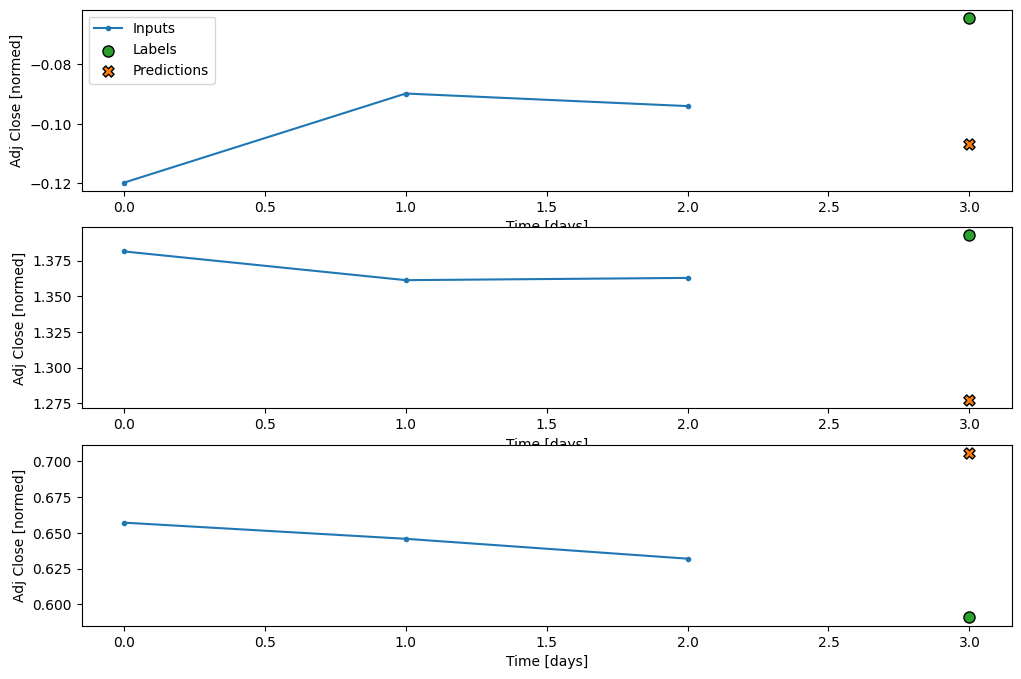

In [15]:
conv_window.windows[0].plot(multi_step_dense)

### Convolutional Neural Network

In [16]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [17]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

111/111 [==============================] - 0s 3ms/step - loss: 0.1875 - mean_absolute_error: 0.3238


2023-04-27 09:35:54.102847: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [2474]
	 [[{{node Placeholder/_8}}]]
2023-04-27 09:35:54.103203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]


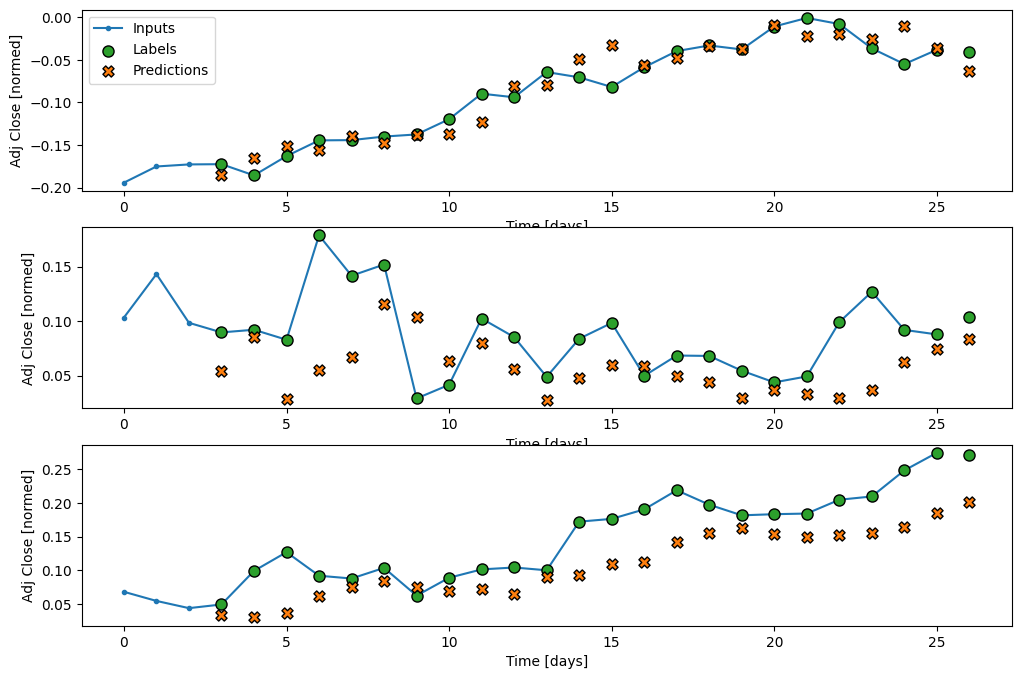

In [18]:
wide_conv_window.windows[0].plot(conv_model)

### LSTM

In [19]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(4, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [20]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

110/110 [==============================] - 1s 5ms/step - loss: 6.6314 - mean_absolute_error: 1.7130


2023-04-27 09:37:01.985386: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_95' with dtype double and shape [354,13]
	 [[{{node Placeholder/_95}}]]
2023-04-27 09:37:01.987520: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_31' with dtype double and shape [354,13]
	 [[{{node Placeholder/_31}}]]


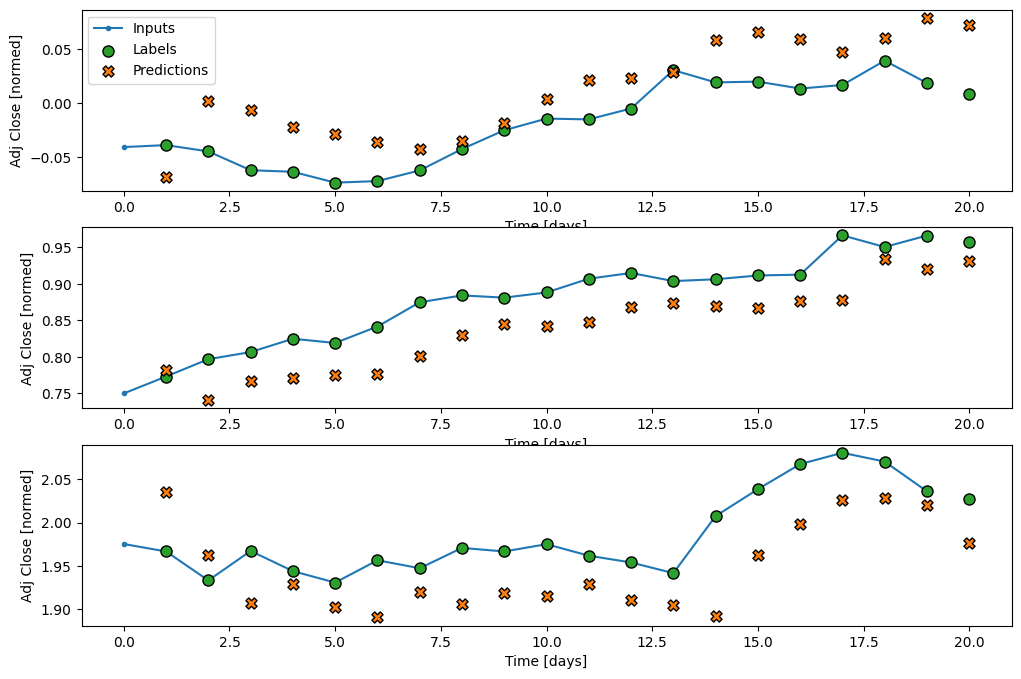

In [21]:
wide_window.windows[0].plot(lstm_model)

## Performance

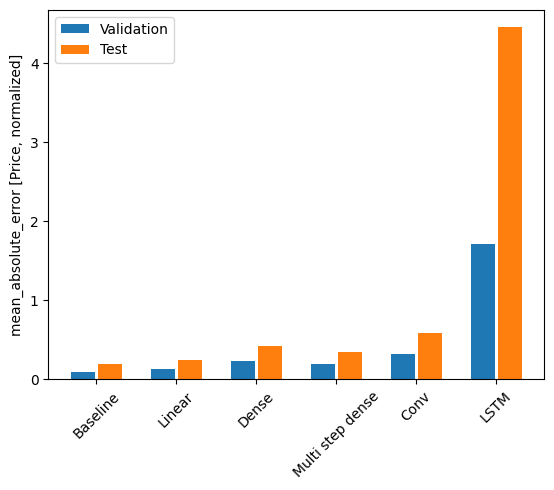

In [22]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [Price, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()
